In [2]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Correlation map

<Axes: >

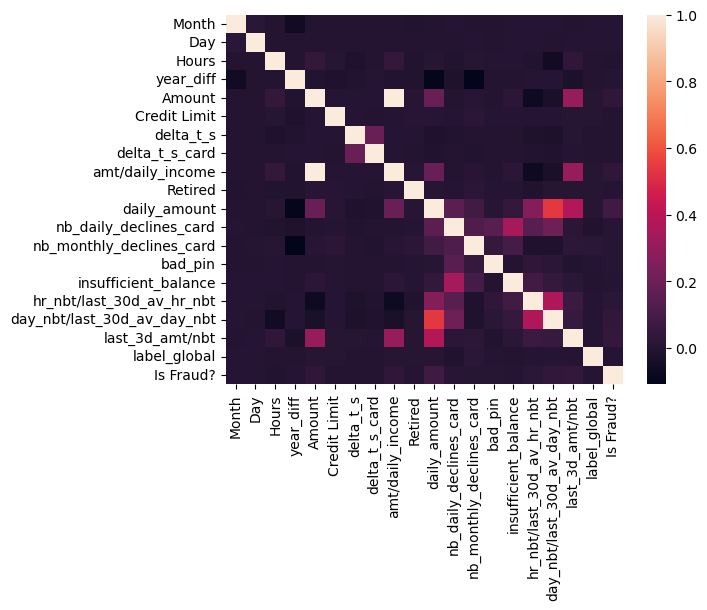

In [3]:
sns.heatmap(df_cct[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?']].corr())

In [4]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?'],
      dtype='object')

### Preprocessing (code to create standarized (by User) dataset) - DO NOT RUN

In [19]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = df_cct.loc[:,~df_cct.columns.isin(["User","Card","label_global","Retired", "bad_pin", "insufficient_balance","Is Fraud?"])].select_dtypes(include=numerics).columns.to_list()
cat = df_cct.select_dtypes(include=['object']).columns.to_list()


In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
df = pd.DataFrame()
for i in range(2000):
    user_i = df_cct[df_cct["User"] == i]
    user_i[num] = scaler.fit_transform(user_i[num])
    df = pd.concat([df,user_i], axis=0)


In [51]:
#df.to_parquet("/home/onyxia/work/df_cct_stand2.parquet")

### Encode categorical variables

In [4]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
# Pour "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [6]:
# Pour "Card Type"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [7]:
# Pour "label global"":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["label_global"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [8]:
df_cct.rename(columns={0:"0", -1: "-1", 1:"1", 2:"2", 3: "3", 4:"4", 5:"5", 6:"6"}, inplace=True)

In [9]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction', 'Amex', 'Discover', 'Mastercard', 'Visa', 'Credit',
       'Debit', 'Debit (Prepaid)', '-1', '0', '1', '2', '3', '4', '5', '6'],
      dtype='object')

### Create train/val/test datasets

In [9]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"Is Fraud?",
        "-1","0","1","2","3","4","5","6"]
df_selec = df_cct[features] # 21 features + clusters
X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]
y = df_selec["Is Fraud?"]

In [10]:
## Splitting the data into train and test data  (70:30)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, shuffle = True, random_state = 0, stratify = y)


In [11]:
df_train = df_selec.loc[X_train.index]

In [12]:
## Checking class distribution in stratified train-test split
from collections import Counter

print("In y dataset:", Counter(y))
print("\nIn y_train set:", Counter(y_train))
print("\nIn y_test set:", Counter(y_rem))

In y dataset: Counter({0: 24357143, 1: 29757})

In y_train set: Counter({0: 17050000, 1: 20830})

In y_test set: Counter({0: 7307143, 1: 8927})


In [13]:
df_rem = df_selec.loc[X_rem.index]

In [14]:
# Now since we want the valid and test size to be equal (15% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)

df_val = df_rem.sample(int(len(X_rem)*0.5), random_state = 0)
X_val = df_val.drop(["Is Fraud?"], axis = 1)
y_val = df_val["Is Fraud?"]
df_test = df_rem.loc[~df_rem.index.isin(df_val.index.tolist())]
X_test = df_test.drop(["Is Fraud?"], axis = 1)
y_test = df_test["Is Fraud?"]


In [15]:
# almost stratified

print("In y dataset:", Counter(y_rem))
print("\nIn y_val set:", Counter(y_val))
print("\nIn y_test set:", Counter(y_test))

In y dataset: Counter({0: 7307143, 1: 8927})

In y_val set: Counter({0: 3653663, 1: 4372})

In y_test set: Counter({0: 3653480, 1: 4555})


## Model Building perso

In [16]:
#Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'Precision','Recall','F1 score', "Our Score"])

In [62]:
# opening raw cct file
cct_init = pd.read_parquet("/home/onyxia/work/df_all.parquet")

#building our own score
def our_score(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = cct_init.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["Amount"]>=15].index

    df_tp = cct_init.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["Amount"]>=15].index

    our_score = -15*(len(fp_new) + len(tp_new)) + cct_init.loc[tp_new].Amount.sum() - cct_init.loc[fn_rows].Amount.sum() - cct_init.loc[tp_rows].Amount.sum()

    our_score_norm = (our_score + cct_init.loc[fn_rows].Amount.sum() + cct_init.loc[tp_rows].Amount.sum())/(cct_init.loc[tp_new].Amount.sum()+cct_init.loc[fp_new].Amount.sum() - 15*(len(tp_new)+len(fp_new)))

    return our_score_norm

In [63]:
# plot confusion matrix
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)


def print_model_metrics(y_test,y_pred):
    print(" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cp)
    plt.show()


In [64]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()


### Decision Tree

In [ ]:
# train : 
# all 70% (integrate label gloabl?)
# clustering from the second smallest cluster
# undersampling
# oversampling
# mix


In [65]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, random_state=None, shuffle=False)
kf.split(X_train)
for train_index, test_index in kf.split(X_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape , str("\n"))
    print("TRAIN:", train_index, "\n\nTEST:", test_index , str("\n"))

TRAIN: (11380553,) TEST: (5690277,) 

TRAIN: [ 5690277  5690278  5690279 ... 17070827 17070828 17070829] 

TEST: [      0       1       2 ... 5690274 5690275 5690276] 

TRAIN: (11380553,) TEST: (5690277,) 

TRAIN: [       0        1        2 ... 17070827 17070828 17070829] 

TEST: [ 5690277  5690278  5690279 ... 11380551 11380552 11380553] 

TRAIN: (11380554,) TEST: (5690276,) 

TRAIN: [       0        1        2 ... 11380551 11380552 11380553] 

TEST: [11380554 11380555 11380556 ... 17070827 17070828 17070829] 



In [70]:
!pip install tqdm
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer

dt_weight1 = pd.DataFrame(columns = ["class_weight_fraud", "f1_score_cv", "our_score_cv"])

cw_range = [40,50,60,70,80,90]
for i in tqdm(cw_range):
    clf = DecisionTreeClassifier(random_state=0, class_weight={1: i/100, 0: 1 - i/100})
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_weight1.loc[len(dt_weight1)] = [i/100, f1_score_cv.mean(), our_score_cv.mean()]
    


100%|██████████| 6/6 [1:54:07<00:00, 1141.29s/it]


In [71]:
dt_weight1

,class_weight_fraud,f1_score_cv,our_score_cv
0,0.4,0.143393,0.091698
1,0.5,0.145092,0.096542
2,0.6,0.146445,0.093592
3,0.7,0.145476,0.088674
4,0.8,0.142242,0.079487
5,0.9,0.138122,0.083759


Text(0, 0.5, 'Metric Scores')

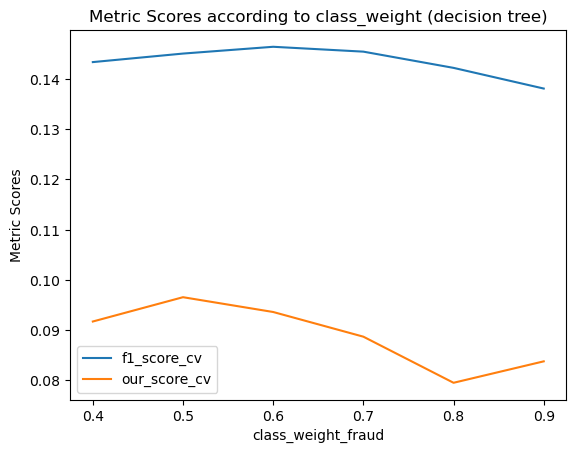

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(dt_weight1, x= "class_weight_fraud", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(dt_weight1, x= "class_weight_fraud", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to class_weight (decision tree)")
plt.ylabel("Metric Scores")


In [72]:
dt_min_samples_leaf1 = pd.DataFrame(columns = ["min_samples_leaf", "f1_score_cv", "our_score_cv"])
min_sample_leaf_range = [1, 5, 10, 20, 50, 100, 200, 300, 500]
for i in tqdm(min_sample_leaf_range):
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.5, 0:0.5}, min_samples_leaf = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_min_samples_leaf1.loc[len(dt_min_samples_leaf1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    

  0%|          | 0/9 [00:00<?, ?it/s]/opt/mamba/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 9/9 [2:43:03<00:00, 1087.09s/it]  


In [73]:
dt_min_samples_leaf1

,min_samples_leaf,f1_score_cv,our_score_cv
0,1.0,0.145092,0.096542
1,5.0,0.169871,0.293272
2,10.0,0.158473,0.413899
3,20.0,0.135477,0.502629
4,50.0,0.103344,0.596364
5,100.0,0.080085,0.643516
6,200.0,0.067926,0.655852
7,300.0,0.046858,0.614628
8,500.0,0.051901,0.609341


Text(0, 0.5, 'Metric Scores')

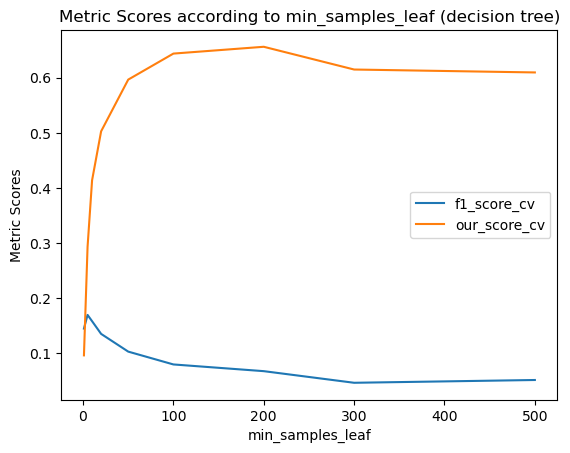

In [87]:
sns.lineplot(dt_min_samples_leaf1, x= "min_samples_leaf", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(dt_min_samples_leaf1, x= "min_samples_leaf", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to min_samples_leaf (decision tree)")
plt.ylabel("Metric Scores")

In [89]:
dt_max_depth1 = pd.DataFrame(columns = ["max_depth", "f1_score_cv", "our_score_cv"])
max_depth_range = [i for i in range (1,25,3)]
for i in tqdm(max_depth_range):
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.5, 0:0.5}, 
    min_samples_leaf = 200, max_depth = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_max_depth1.loc[len(dt_max_depth1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
    

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
 12%|█▎        | 1/8 [02:32<17:45, 152.26s/it]/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 8/8 [1:12:18<00:00, 542.32s/it]


In [91]:
for i in tqdm([5,6]): 
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.5, 0:0.5}, 
    min_samples_leaf = 200, max_depth = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_max_depth1.loc[len(dt_max_depth1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]

100%|██████████| 2/2 [10:54<00:00, 327.47s/it]


In [92]:
dt_max_depth1

,max_depth,f1_score_cv,our_score_cv
0,1.0,0.000000,NaN
1,4.0,0.000000,NaN
2,7.0,0.055058,0.706270
3,10.0,0.067926,0.655852
4,13.0,0.067926,0.655852
5,16.0,0.067926,0.655852
6,19.0,0.067926,0.655852
7,22.0,0.067926,0.655852
8,5.0,0.039878,0.739863
9,6.0,0.047959,0.743878


Text(0, 0.5, 'Metric Scores')

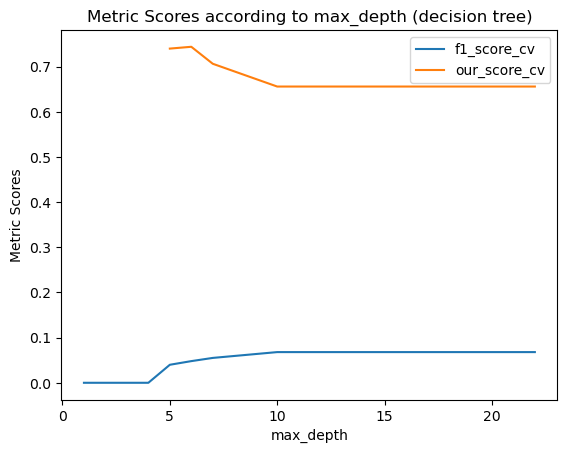

In [95]:
sns.lineplot(dt_max_depth1, x= "max_depth", y ="f1_score_cv", label ="f1_score_cv")
sns.lineplot(dt_max_depth1, x= "max_depth", y ="our_score_cv", label = "our_score_cv")
plt.title("Metric Scores according to max_depth (decision tree)")
plt.ylabel("Metric Scores")

In [97]:
dt_max_features1 = pd.DataFrame(columns = ["max_features", "f1_score_cv", "our_score_cv"])

max_features_range = ["auto", "sqrt", "log2", None]
for i in tqdm(max_features_range): 
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.5, 0:0.5}, 
    min_samples_leaf = 200, max_depth = 6, max_features = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_max_features1.loc[len(dt_max_features1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
dt_max_features1

  0%|          | 0/4 [00:00<?, ?it/s]/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
 50%|█████     | 2/4 [05:40<05:38, 169.42s/it]/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in d

,max_features,f1_score_cv,our_score_cv
0,auto,0.017526,0.543209
1,sqrt,0.017526,0.543209
2,log2,0.000000,NaN
3,NaN,0.047959,0.743878


In [99]:
dt_criterion1 = pd.DataFrame(columns = ["criterion", "f1_score_cv", "our_score_cv"])

criterion_range = ["gini", "entropy"]
for i in tqdm(criterion_range): 
    clf = DecisionTreeClassifier(random_state=0, class_weight = {1:0.5, 0:0.5}, 
    min_samples_leaf = 200, max_depth = 6, criterion = i)
    scores = cross_validate(clf, X_train, y_train, cv = kf, 
    scoring = {"our_score_cv" : our_score, "f1": make_scorer(f1_score)}, 
    n_jobs = -1)
    our_score_cv = scores["test_our_score_cv"]
    f1_score_cv = scores["test_f1"]
    dt_criterion1.loc[len(dt_criterion1)] = [i, f1_score_cv.mean(), our_score_cv.mean()]
dt_criterion1

 50%|█████     | 1/2 [06:13<06:13, 373.67s/it]/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
/tmp/ipykernel_3380/3912150626.py:43: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 2/2 [12:35<00:00, 377.91s/it]


,criterion,f1_score_cv,our_score_cv
0,gini,0.047959,0.743878
1,entropy,0.000000,NaN


### Random Forest